In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_msssim import ssim
from torchvision.utils import save_image
from pytorch_fid import fid_score
import time
import os
import re
import shutil
from torch.autograd import Variable
from torchvision.models import inception_v3
from scipy.stats import entropy
import torch.nn.functional as F
from torchvision.models import inception_v3
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from scipy.stats import entropy
from scipy.linalg import sqrtm
from torchmetrics.image.fid import FrechetInceptionDistance




rebuild_path = 'rebuild'

# Verificar se a pasta existe
if os.path.exists(rebuild_path) and os.path.isdir(rebuild_path):
    # Eliminar a pasta e todo o seu conteúdo
    shutil.rmtree(rebuild_path)

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

In [2]:
train_dataset_path = 'TRAIN_augmented'

IMG_WIDTH = 75
IMG_HEIGHT = 75
BATCH_SIZE = 64

In [3]:
transform = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),   # Redimensiona todas as imagens para 75x75 pixels
    transforms.ToTensor(),         # Converte as imagens para tensores do PyTorch
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]

])

full_dataset = datasets.ImageFolder(root=train_dataset_path, transform=transform)

data_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)


In [4]:
def visualize_images(images, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for img, ax in zip(images[:5], axes):
        img = img.permute(1, 2, 0)  # Reordenar dimensões para (H, W, C)
        ax.imshow(img)
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

In [5]:
# get how many images we have for each class

traffic_signals_dataset = datasets.ImageFolder(root=train_dataset_path)
print("Classes encontradas:", traffic_signals_dataset.classes)

class_count_true = {}

for _, label in traffic_signals_dataset:
    
    if label not in class_count_true:
        class_count_true[label] = 0
        
    class_count_true[label] += 1
    
print(class_count_true)

Classes encontradas: ['12', '13', '24', '37', '38', '39', '44', '50', '6']
{0: 96, 1: 72, 2: 100, 3: 58, 4: 60, 5: 68, 6: 60, 7: 70, 8: 78}


In [6]:
class CVAE(nn.Module):
    def __init__(self, color_channels=3, num_labels=10, latent_dim=128):
        super().__init__()
        self.num_labels = num_labels
        self.latent_dim = latent_dim
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(color_channels + num_labels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128 * 19 * 19, 128)
        self.fc_log_var = nn.Linear(128 * 19 * 19, 128)
        # Decoder
        self.decoder_input = nn.Linear(128 + num_labels, 128 * 19 * 19)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, color_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, labels):
        # Encode
        labels_onehot = F.one_hot(labels, num_classes=self.num_labels).float()
        labels_onehot = labels_onehot.unsqueeze(-1).unsqueeze(-1)
        labels_onehot = labels_onehot.expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat((x, labels_onehot), dim=1)
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        z = self.reparameterize(mu, log_var)
        # Decode
        z = torch.cat((z, F.one_hot(labels, num_classes=self.num_labels).float()), dim=1)
        x = self.decoder_input(z)
        x = x.view(-1, 128, 19, 19)
        x = self.decoder(x)
        return x, mu, log_var

    def decode(self, z, labels):
        labels_onehot = F.one_hot(labels, num_classes=self.num_labels).float()
        z = torch.cat((z, labels_onehot), dim=1)
        z = self.decoder_input(z)
        z = z.view(-1, 128, 19, 19)
        return self.decoder(z)
    
def loss_function(recon_x, x, mu, log_var):
    BCE = torch.nn.functional.binary_cross_entropy(recon_x, x, reduction='mean')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / mu.size(0)
    return BCE + KLD



Epoch 0, BCE: 0.6858778216622092, KLD: 1.337363463995809
Epoch 1, BCE: 0.677904340353879, KLD: 0.0010878659112759951
Epoch 2, BCE: 0.6755163723772223, KLD: 0.00021592015003658491
Epoch 3, BCE: 0.6734069098125804, KLD: 7.056811624682847e-05
Epoch 4, BCE: 0.6722824356772683, KLD: 2.8198696534011766e-05
Epoch 5, BCE: 0.6697980707341974, KLD: 1.1120156986263199e-05
Epoch 6, BCE: 0.6675834493203596, KLD: 6.6814005053443415e-06
Epoch 7, BCE: 0.6663005189462141, KLD: 5.571902833749349e-06
Epoch 8, BCE: 0.6641989567063071, KLD: 4.719677277038996e-06
Epoch 9, BCE: 0.6649123105135831, KLD: 3.923388765708131e-06
Epoch 10, BCE: 0.6632259433919733, KLD: 4.025580272520363e-06
Epoch 11, BCE: 0.6645511822267012, KLD: 4.6937464668934066e-06
Epoch 12, BCE: 0.6625837792049755, KLD: 4.571850984740939e-06
Epoch 13, BCE: 0.6612861102277582, KLD: 5.746321841632545e-06
Epoch 14, BCE: 0.6613671725446527, KLD: 3.961284350721557e-06
Epoch 15, BCE: 0.659594947641546, KLD: 3.3878590412231544e-06
Epoch 16, BCE: 0.6

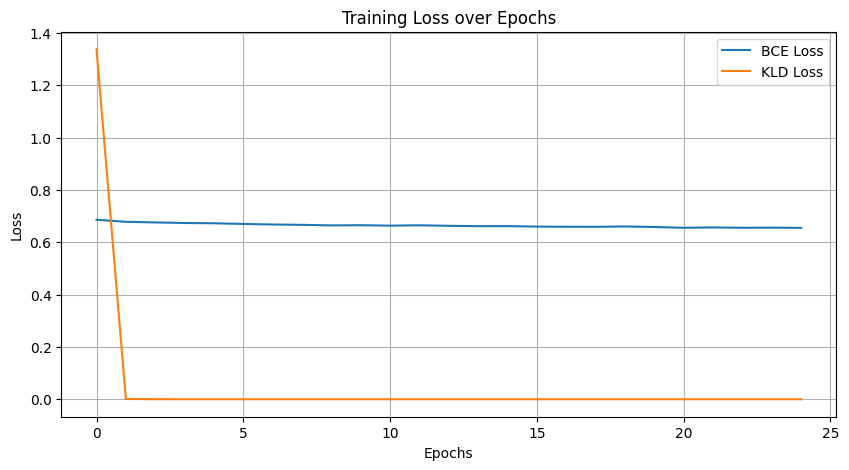

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVAE(color_channels=3, num_labels=len(full_dataset.classes)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 25

bce_list = []
kld_list = []

for epoch in range(num_epochs):
    model.train()
    total_bce = 0
    total_kld = 0
    for idx, (data, labels) in enumerate(data_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data, labels)
        BCE = torch.nn.functional.binary_cross_entropy(recon_batch, data, reduction='mean')
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / data.shape[0]  # per sample
        loss = BCE + KLD
        loss.backward()
        optimizer.step()
        total_bce += BCE.item()
        total_kld += KLD.item()
    
    bce_list.append(total_bce / len(data_loader))
    kld_list.append(total_kld / len(data_loader))
    
    print(f'Epoch {epoch}, BCE: {total_bce / len(data_loader)}, KLD: {total_kld / len(data_loader)}')


plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), bce_list, label='BCE Loss')
plt.plot(range(num_epochs), kld_list, label='KLD Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


## Inception Score

In [8]:
# Função para calcular Inception Score
def inception_score(imgs, device, batch_size=32, resize=True, splits=10):
    N = len(imgs)
    
    # Inception v3 model
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()
    
    def get_pred(x):
        if resize:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        x = inception_model(x)
        return F.softmax(x, dim=1).data.cpu().numpy()

    preds = np.zeros((N, 1000))

    dataloader = DataLoader(TensorDataset(imgs), batch_size=batch_size)

    for i, batch in enumerate(dataloader, 0):
        batch = batch[0].to(device)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batch)

    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)


In [9]:
# Geração de imagens para calcular Inception Score
num_image = 50
model.eval()
generated_images = []
with torch.no_grad():
    for i in range(num_image):
        z = torch.randn(1, 128).to(device)
        label = torch.randint(0, 10, (1,)).to(device)
        sample = model.decode(z, label).cpu()
        generated_images.append(sample)

generated_images = torch.cat(generated_images, dim=0)
generated_images = generated_images.view(num_image, 3, 75, 75)  # Certifique-se de que as imagens geradas tenham 3 canais e 75x75 de tamanho

# Calcular Inception Score
mean, std = inception_score(generated_images, device)
print(f'Inception Score: {mean} +/- {std}')

# Preparar o objeto FID
fid = FrechetInceptionDistance(feature=2048).to(device)

# Carregar imagens reais do DataLoader
real_images = []
for i, (data, _) in enumerate(data_loader):
    real_images.append(data)
    if len(real_images) * data.shape[0] >= num_image:
        break

real_images = torch.cat(real_images, dim=0)[:num_image]  # Certifique-se de ter o mesmo número de imagens reais que imagens geradas

# Converta as imagens para uint8
real_images = (real_images * 255).byte()
generated_images = (generated_images * 255).byte()

# Mover para o dispositivo (GPU/CPU)
real_images = real_images.to(device)
generated_images = generated_images.to(device)

# Calcular FID
fid.update(real_images, real=True)
fid.update(generated_images, real=False)

fid_score = fid.compute()
print(f'FID Score: {fid_score.item()}')


RuntimeError: Class values must be smaller than num_classes.

RuntimeError: Class values must be smaller than num_classes.

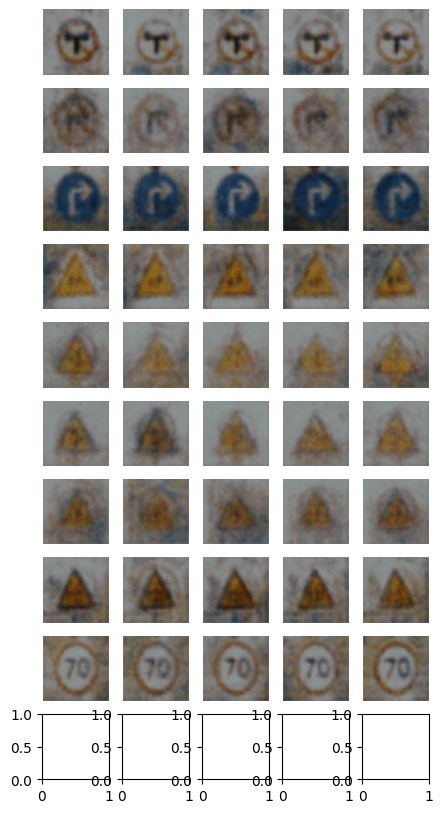

In [10]:
def generate_and_plot_images(model, device, num_labels, num_images=5):
    model.eval()
    fig, axes = plt.subplots(num_labels, num_images, figsize=(num_images * 1, num_labels * 1))
    
    for i in range(num_labels):
        for j in range(num_images):
            z = torch.randn(1, 128).to(device)
            label = torch.tensor([i]).to(device)  # Label desejada
            with torch.no_grad():
                image = model.decode(z, label)
            image = image.cpu().view(3, 75, 75)
            ax = axes[i, j]
            ax.imshow(image.permute(1, 2, 0))  # Ajustar a permutação para visualização
            ax.axis('off')
        axes[i, 0].set_ylabel(f'Label {i}')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

generate_and_plot_images(model, device, num_labels=10)  